# Shen_ISC Analysis

In [1]:
# Import functions helpful for managing file paths
import glob
from os.path import join
from brainiak.isc import (isc, isfc, bootstrap_isc, permutation_isc,
                          timeshift_isc, phaseshift_isc,
                          compute_summary_statistic)
from brainiak.io import load_boolean_mask, load_images
from brainiak.image import mask_images, MaskedMultiSubjectData
import nibabel as nib
import numpy as np
import pandas as pd

from scipy.stats import norm, pearsonr, zscore
from nilearn import image
from nilearn.image import index_img
import nibabel

/usr/local/anaconda3/envs/fmri/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


Extract ROIs according to the `Shen Atlas`

In [2]:
shen = '/home/fhopp/Downloads/shenetal_neuroimage2013/fconn_atlas_150_2mm.nii'

In [3]:
from nilearn.input_data import NiftiLabelsMasker

In [4]:
# Extract signals on a parcellation defined by labels
# Atlas will be resampled to functional space (=mask_img)
masker = NiftiLabelsMasker(labels_img=shen, mask_img='isc_functional_mask.nii.gz', 
                           resampling_target='data', memory='nilearn_cache', verbose=5)

Feed in a few of the `functional runs`

In [5]:
func_fns = glob.glob('/srv/lab/fmri/mft/dicom4bids/bids_nii/derivatives/isc/*/first,_do_no_harm_harm_bold.nii.gz')[:5]

#Make a list to store files that could not be transformed
problems = []

# Keep even subject and odd subject numbers separated as they received different conditions
even_time_series = []
odd_time_series = []
for f in func_fns:
    sub = int(f.split('/')[-2].split('-')[-1])
    if sub % 2 == True:
#         try:
            # This is where I apply the above masker to obtain an average activation per ROI
            odd_time_series.append(masker.fit_transform(f))
#         except:
            problems.append(f)
    else:
        try:
            # This is where I apply the above masker to obtain an average activation per ROI
            even_time_series.append(masker.fit_transform(f))
        except:
            problems.append(f)

[NiftiLabelsMasker.fit_transform] loading data from /home/fhopp/Downloads/shenetal_neuroimage2013/fconn_atlas_150_2mm.nii
[NiftiLabelsMasker.fit_transform] loading data from isc_functional_mask.nii.gz


/usr/local/anaconda3/envs/fmri/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


Resampling labels
[Memory]    0.1s, 0.0min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from /home/fhopp/Downloads/shenetal_neuroimage2013/fconn_atlas_150_2mm.nii
[NiftiLabelsMasker.fit_transform] loading data from isc_functional_mask.nii.gz


/usr/local/anaconda3/envs/fmri/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


[Memory]    3.3s, 0.1min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from /home/fhopp/Downloads/shenetal_neuroimage2013/fconn_atlas_150_2mm.nii
[NiftiLabelsMasker.fit_transform] loading data from isc_functional_mask.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/srv/lab/fmri/mft/dicom4bids/bids_nii/derivatives/isc/sub-49/first,_do_no_harm_harm_bold.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'labels_img': '/home/fhopp/Downloads/shenetal_neuroimage2013/fconn_atlas_150_2mm.nii',
  'low_pass': None,
  'mask_img': 'isc_functional_mask.nii.gz',
  'smoothing_fwhm': None,
  'standardize': False,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, dtype=None, memory=Memory

/usr/local/anaconda3/envs/fmri/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
_______________________________________________filter_and_extract - 5.7s, 0.1min
[NiftiLabelsMasker.fit_transform] loading data from /home/fhopp/Downloads/shenetal_neuroimage2013/fconn_atlas_150_2mm.nii
[NiftiLabelsMasker.fit_transform] loading data from isc_functional_mask.nii.gz
[Memory]   14.9s, 0.2min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from /home/fhopp/Downloads/shenetal_neuroimage2013/fconn_atlas_150_2mm.nii
[NiftiLabelsMasker.fit_transform] loading data from isc_functional_mask.nii.gz
[Memory]   17.8s, 0.3min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


Check the shape of a single subject time-series

In [6]:
even_time_series[0]

array([[6223.7817, 6087.0635, 2881.6965, ..., 6937.89  , 4914.83  ,
        5575.81  ],
       [6238.673 , 6118.927 , 2876.7979, ..., 6943.664 , 4920.918 ,
        5587.7163],
       [6230.9263, 6096.851 , 2880.4578, ..., 6927.4067, 4944.602 ,
        5571.0503],
       ...,
       [6241.7974, 6045.5737, 2868.3267, ..., 6921.1934, 4924.575 ,
        5587.8237],
       [6247.1836, 6072.7354, 2883.393 , ..., 6919.247 , 4910.65  ,
        5587.305 ],
       [6227.213 , 6063.65  , 2877.8274, ..., 6904.558 , 4932.133 ,
        5576.901 ]], dtype=float32)

In [7]:
even_time_series[0].shape

(32, 278)

So, 32 `TRs` and 278 averaged signals per `ROI` 

### ISC Analysis

The following steps for calculating the ISCs are adpated from the `isc_tutorial`.

First, I stack all the time series together:

In [8]:
# Stack numpy arrays to yield a n_TRs by n_voxels (ROIs) by n_subjects array
orig_data = np.stack(even_time_series, axis=2)

In [9]:
# Check shape and z-score
print(f"Original fMRI data shape: {orig_data.shape} "
      f"\ni.e., {orig_data.shape[0]} time points, {orig_data.shape[1]} ROIs, "
      f"{orig_data.shape[2]} subjects")

# Z-score time series for each voxel
data = zscore(orig_data, axis=0)

Original fMRI data shape: (32, 278, 3) 
i.e., 32 time points, 278 ROIs, 3 subjects


In [10]:
# Leave-one-out approach
iscs = isc(data, pairwise=False, tolerate_nans=.8)


# Check shape of output ISC values
print(f"ISC values shape = {iscs.shape} \ni.e., {iscs.shape[0]} "
      f"left-out subjects and {iscs.shape[1]} voxel(s)")

ISC values shape = (3, 278) 
i.e., 3 left-out subjects and 278 voxel(s)


In [11]:
# Compute mean ISC (with Fisher transformation)
mean_iscs = compute_summary_statistic(iscs, summary_statistic='mean', axis=0)

print(f"ISC values shape = {mean_iscs.shape} \ni.e., {mean_iscs.shape[0]} "
      f"mean value across left-out subjects and {iscs.shape[1]} voxel(s)"
      f"\nMinimum mean ISC across voxels = {np.nanmin(mean_iscs):.3f}; "
      f"maximum mean ISC across voxels = {np.nanmax(mean_iscs):.3f}")

ISC values shape = (278,) 
i.e., 278 mean value across left-out subjects and 278 voxel(s)
Minimum mean ISC across voxels = -0.662; maximum mean ISC across voxels = 0.642


In [12]:
# Run bootstrap hypothesis test on ISCs
observed, ci, p, distribution = bootstrap_isc(iscs, pairwise=False,
                                              ci_percentile=95,
                                              summary_statistic='median',
                                              n_bootstraps=1000)

In [14]:
# Get number of NaN ROIs (i.e., ROIs in which there where no signficant ISCs)
n_nans = np.sum(np.isnan(observed))
print(f"{n_nans} ROIs out of {observed.shape[0]} are NaNs "
      f"({n_nans / observed.shape[0] * 100:.2f}%)")

# Get ROIs without NaNs
nonnan_mask = ~np.isnan(observed)
nonnan_coords = np.where(nonnan_mask)

# Mask both the ISC and p-value map to exclude NaNs
nonnan_isc = observed[nonnan_mask]
nonnan_p = p[nonnan_mask]

0 ROIs out of 278 are NaNs (0.00%)


In [15]:
from statsmodels.stats.multitest import multipletests

In [16]:
# Get FDR-controlled q-values
nonnan_q = multipletests(nonnan_p, method='fdr_by')[1]
threshold = .05
print(f"{np.sum(nonnan_q < threshold)} significant regions "
      f"controlling FDR at {threshold}")

# Threshold ISCs according FDR-controlled threshold
nonnan_isc[nonnan_q >= threshold] = np.nan

# Reinsert thresholded ISCs back into whole brain image
isc_thresh = np.full(observed.shape, np.nan)
isc_thresh[nonnan_coords] = nonnan_isc

100 significant regions controlling FDR at 0.05


## Plotting the ISC Thresh Matrix

This is where I fail. So, `isc_thresh` is an array with 278 entries (one ISC per ROI), nan indicate non-sig. ISC for that ROI:

In [17]:
isc_thresh

array([        nan,  0.62789577, -0.3014645 ,  0.19048832,         nan,
               nan,         nan,         nan,         nan, -0.19150871,
               nan, -0.19820029,         nan,         nan,         nan,
               nan,  0.19387527,         nan, -0.31091249,  0.35250017,
               nan,  0.20443498,         nan,         nan, -0.17220649,
        0.32660425,         nan,         nan,         nan,         nan,
       -0.39465988,         nan,         nan,         nan,  0.27290788,
               nan,         nan, -0.31001303, -0.15796107,  0.43484452,
               nan,         nan,         nan,         nan, -0.34361568,
               nan,         nan,         nan,         nan, -0.28844613,
               nan, -0.30058375,         nan,         nan,         nan,
               nan, -0.19591101,         nan, -0.26446593,  0.47895157,
        0.2560499 ,         nan,  0.38350284,         nan,         nan,
               nan,  0.32717958, -0.13854988,  0.30041862,      

Now, how do I get these ISC values "back" into a coordinate space that I can plot them?

In other words, how can I link these ISC to the corresponding ROIs?

The ISC tutorial suggests to create an empty nifti and then populate that nifti with the ISC values, but here I am just lost.

In [89]:
# Something along those lines?
# Load a NIfTI of the brain mask as a reference Nifti1Image
shen_subspace = 'isc_shen.nii.gz' # shen_subspace is the shen atlas resampled to subject space 

ref_nii = nib.load(shen) 

# # Load masks using brainiak.io
mask_img = load_boolean_mask(shen)

# # Get coordinates of mask voxels in original image
mask_coords = np.where(mask_img)

In [82]:
ref_nii.shape

(91, 109, 91)

In [90]:
len(mask_coords[0])

160694

In [23]:
# I can also get the coordinates of the shen atlas:
from nilearn.plotting import find_parcellation_cut_coords

/usr/local/anaconda3/envs/fmri/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [26]:
shen_coords = find_parcellation_cut_coords(shen)

/usr/local/anaconda3/envs/fmri/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


For example, here are the coordinates for the first five ROIs:

In [44]:
shen_coords[:5]

array([[ 55.90664273,   6.35547576,  20.93716338],
       [ 14.71041369,  29.40085592,  55.00142653],
       [ 12.69565217,  58.71936759, -15.38735178],
       [ 34.375     , -27.79166667,  62.90384615],
       [ 59.31921824, -21.87296417,  32.01302932]])

Here are the next steps according to the isc_tutorial:

In [92]:
# Create empty 3D image and populate
# with thresholded ISC values
isc_img = np.full(ref_nii.shape, np.nan)
isc_img[mask_coords] = isc_thresh

# # # Convert to NIfTI image
isc_nii = nib.Nifti1Image(isc_img, ref_nii.affine, ref_nii.header)

ValueError: shape mismatch: value array of shape (278,) could not be broadcast to indexing result of shape (160694,)

In [85]:
from nilearn.plotting import plot_stat_map

In [86]:
%matplotlib inline

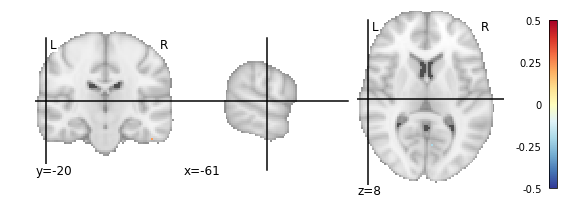

In [87]:
# Plot slices at coordinates -61, -20, 8
plot_stat_map(
    isc_nii,
    cmap='RdYlBu_r',
    vmax=.5,
    cut_coords=(-61, -20, 8))